## Bird info 

In [14]:
query = """SELECT birdID, MIN(dphSurgery) AS dphSurgeryMin, MAX(dphSurgery) AS dphSurgeryMax, 
        MIN(dphDeafening) AS dphDeafeningMin, MAX(dphDeafening) AS dphDeafeningMax 
        FROM bird
        GROUP BY birdID ORDER BY dphSurgeryMin ASC
        """

df = db.to_dataframe(query)
df

,birdID,dphSurgeryMin,dphSurgeryMax,dphDeafeningMin,dphDeafeningMax
0,w16w14,79,79,113.0,113.0
1,y44r34,87,87,118.0,118.0
2,g35r38,93,93,130.0,130.0
3,b4r64,94,94,108.0,108.0
4,b70r38,98,98,119.0,119.0
5,w21w30,100,100,119.0,119.0
6,b14r74,105,105,127.0,127.0
7,g70r40,118,118,NaN,NaN
8,k27o36,136,136,129.0,129.0
9,o25w75,191,191,173.0,173.0


## Plot cluster information (e.g., number of cluster for each bird, categories, etc

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pyfinch.database.load import ProjectLoader
from pyfinch.utils.draw import remove_right_top
from pyfinch.utils import save
import sys
sys.path.append(r"..")

## bursting vs. non-bursting neurons

In [3]:
# Load database
db = ProjectLoader().load_db()
# # SQL statement
df = db.to_dataframe("SELECT unitCategoryUndir FROM unit_profile")
unit_category = df['unitCategoryUndir']

In [4]:
explode = (0.1, 0)
colors = ['#66b3ff', '#ff9999']
values = [sum(unit_category == 'Bursting'), sum(unit_category == 'NonBursting')]
values
unit_category.unique()

array(['Bursting', 'NonBursting', None], dtype=object)

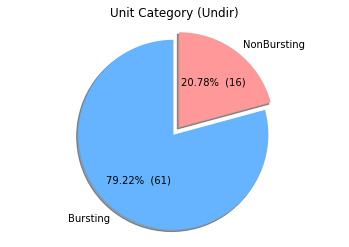

In [5]:
def plot_cluster_pie_chart(save_fig=False, save_dir_name='Results', fig_ext='.png'):
    
    # Load database
    db = ProjectLoader().load_db()
    # # SQL statement
    df = db.to_dataframe("SELECT unitCategoryUndir FROM unit_profile")
    unit_category = df['unitCategoryUndir'].dropna()

    explode = (0.1, 0)
    colors = ['#66b3ff', '#ff9999']
    values = [sum(unit_category == 'Bursting'), sum(unit_category == 'NonBursting')]

    fig, ax = plt.subplots()
    ax.pie(values, explode=explode, colors=colors,
           shadow=True, labels=unit_category.unique(), startangle=90,
           autopct=lambda p: '{:.2f}%  ({:,.0f})'.format(p, p * sum(values) / 100))

    plt.title('Unit Category (Undir)')
    ax.axis('equal')

    # Save results
    if save_fig:
        save_path = save.make_dir(ProjectLoader().path / 'Analysis', save_dir_name)
        save.save_fig(fig, save_path, 'ClusterInfo', fig_ext=fig_ext)
    else:
        plt.show()

plot_cluster_pie_chart()

## \# of bursting units per bird per task

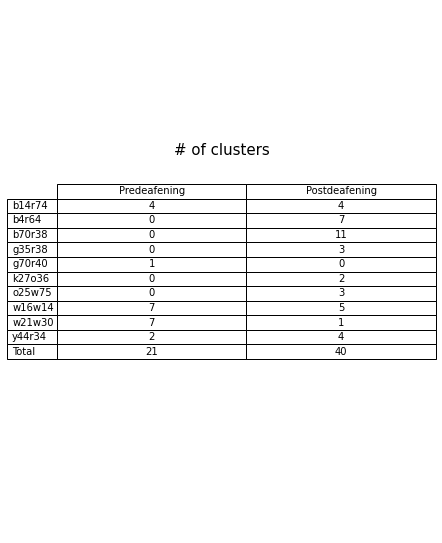

In [6]:
def get_nb_clusters(save_fig=False, save_dir_name='Results', fig_ext='.png'):
    
    from util.plot import get_nb_cluster

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    plt.suptitle("# of clusters", y=0.7, fontsize=15)
    get_nb_cluster(ax)
    plt.axis('off')
    plt.tight_layout()

    # Save results
    if save_fig:
        save_path = save.make_dir(ProjectLoader().path / 'Analysis', save_dir_name)
        save.save_fig(fig, save_path, 'ClusterInfo', fig_ext=fig_ext)
    else:
        plt.show()
        
get_nb_clusters()

## Recording days

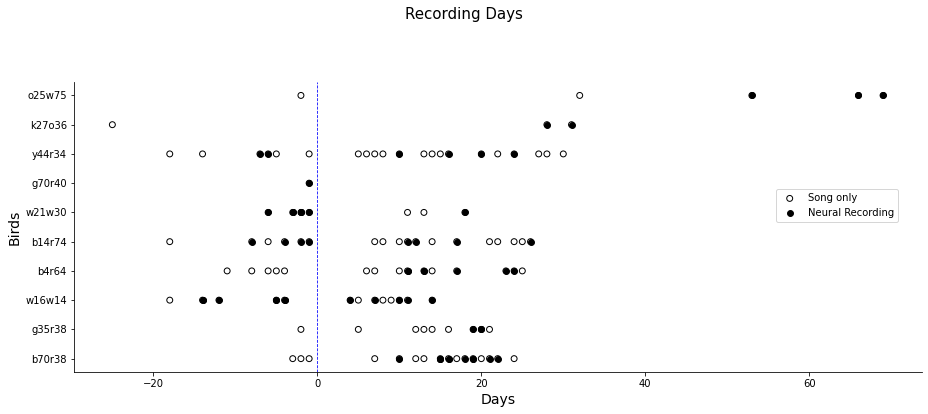

In [7]:
circ_size = 35
save_fig = False
fig_ext = '.png'

# Load database
db = ProjectLoader().load_db()
song_df = db.to_dataframe(f"SELECT * FROM song")
song_df.set_index('id')
cluster_df = db.to_dataframe(f"SELECT * FROM cluster WHERE analysisOK=TRUE")
cluster_df.set_index('id')
bird_df = db.to_dataframe(f"SELECT * FROM bird")
bird_df.set_index('id')

# Plot figure
fig, ax = plt.subplots(figsize=(13, 6))
plt.suptitle('Recording Days', y=.95, fontsize=15)

ax = plt.subplot2grid((6, 1), (1, 0), rowspan=5, colspan=1)
for ind, bird in enumerate(song_df['birdID'].unique()):
    bird_df = song_df[(song_df['birdID'] == bird)]

    ax.scatter(bird_df['taskSessionDeafening'], len(bird_df['taskSessionDeafening']) * [ind+1],
               s=circ_size, color='k', facecolors='none')

    cell_recording_days = cluster_df[cluster_df['birdID'] == bird]['taskSessionDeafening']
    ax.scatter(cell_recording_days, len(cell_recording_days) * [ind+1],
               s=circ_size, color='k')

ax.legend(['Song only', 'Neural Recording'], loc='lower center', bbox_to_anchor=(0.9, 0.5))
ax.set_yticks(range(1, len(song_df['birdID'].unique())+1))
ax.set_yticklabels(song_df['birdID'].unique())
ax.set_xlabel('Days', fontsize=14)
ax.set_ylabel('Birds', fontsize=14)
ax.axvline(x=0, color='b', ls='--', lw=0.8)

fig.tight_layout()
remove_right_top(ax)
plt.show()

## Recording across age

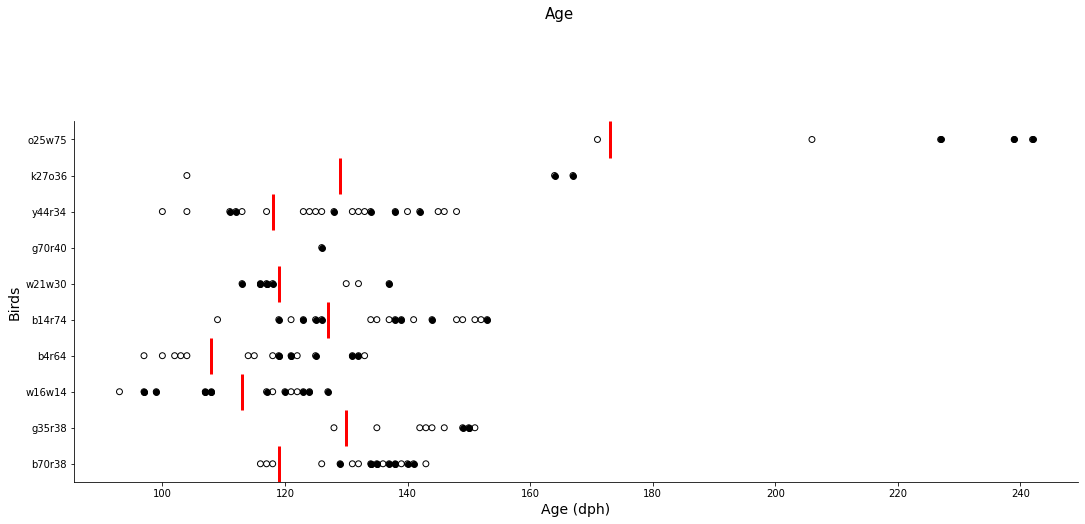

In [8]:
# Load database
db = ProjectLoader().load_db()
bird_df = db.to_dataframe(f"SELECT * FROM bird")
bird_df.set_index('id')

# Plot across age (dph)
fig, ax = plt.subplots(figsize=(18, 8))
plt.suptitle('Age', y=.95, fontsize=15)

ax = plt.subplot2grid((6, 1), (1, 0), rowspan=5, colspan=1)
ax.set_yticks(range(1, len(song_df['birdID'].unique())+1))
ax.set_yticklabels(song_df['birdID'].unique())
line_offsets = np.arange(0.5, len(song_df['birdID'].unique()))
surgery_age = np.array([], dtype=int)
for ind, bird in enumerate(song_df['birdID'].unique()):
    temp_df = song_df[(song_df['birdID'] == bird)]
    for age in temp_df['dph']:
        ax.scatter(age, ind+1,
                   s=circ_size, color='k', facecolors='none')

    ages = cluster_df[cluster_df['birdID'] == bird]['dph']
    for age in ages:
        ax.scatter(age, ind+1,
                   s=circ_size, color='k')

    surgery_age = bird_df.query(f"birdID == '{bird}'")['dphDeafening'].to_list()

    if surgery_age:
        # print(bird, surgery_age)
        ax.eventplot(surgery_age, colors='r', lineoffsets=[ind+1],
                     linelengths=1, linewidths=3, orientation='horizontal')

ax.set_xlabel('Age (dph)', fontsize=14)
ax.set_ylabel('Birds', fontsize=14)
ax.set_ylim([0.5, 10.5])
# fig.tight_layout()
remove_right_top(ax)
plt.show()